# **Lab 4.1 Data Augmentation with PyTorch**

In [1]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset
from torch.nn import functional as F
import random
import cv2
import numpy as np
from skimage.util import random_noise
import matplotlib.pyplot as plt
import os

Complete the `load_data()` function that loads the image using `ImageFolder()` with the specific `transforms.compose()` provided below.
`load_data()` will return DataLoader() and print the information about the Dataset.

`transforms.Compose()` :
- `transforms.Resize()`
- `transforms.ToTensor()`
- `transforms.Pad()`
- `transforms.RandomAffine(degrees=45, translate=(0.1, 0.1),scale=(0.8, 1.2), shear=45)`
- `transforms.CenterCrop()`

Resource : [`transforms.Compose()`](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html#compose), [`torchvision.transforms v1`](<https://pytorch.org/vision/stable/transforms.html#v1-api-reference:~:text=custom)%20tv_tensor%20type.-,V1%20API%20Reference,-Geometry>), [`ImageFolder`](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html), [`Dataloader`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#:~:text=Preparing%20your%20data%20for%20training%20with%20DataLoaders)

In [2]:
def load_data(path):
    ### START CODE HERE ###
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.Pad(padding=10, padding_mode='reflect'),
        transforms.RandomAffine(degrees=45, 
                                translate=(0.1, 0.1), 
                                scale=(0.8, 1.2), 
                                shear=45
                                ),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor()
    ])

    dataset = ImageFolder(path, transform=transform)

    data_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=False)
    return data_loader

    ### END CODE HERE ###

Use your load_data() function to load the dataset in the cell below. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
📃Train Dataset:
	Number of images in class battleship: 44
	Number of images in class patrol boat: 35
	Number of images in class submarine: 35
	Number of samples: 114
```


![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/01.png?raw=true)

</details>

📃Train Dataset:
	Number of images in class battleship: 44
	Number of images in class patrol boat: 35
	Number of images in class submarine: 35
	Number of samples: 114


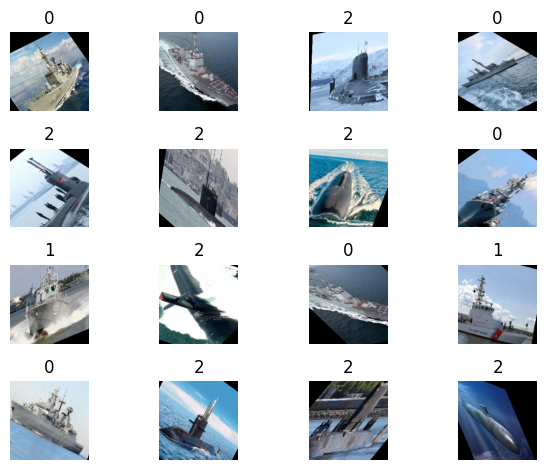

In [3]:
def print_dataset_info(dataset, name="Train"):
    print(f"📃{name} Dataset:")
    for class_name, idx in dataset.class_to_idx.items():
        count = sum(1 for _, label in dataset if label == idx)
        print(f"\tNumber of images in class {class_name}: {count}")
    print(f"\tNumber of samples: {len(dataset)}")

### START CODE HERE ###
# import zipfile

# zip_path = "./Ship.zip"
# extract_path = "./data"

# if not os.path.exists(extract_path):
#     os.makedirs(extract_path)

# # extract zip file
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

path = "./Ship"
test_path = "Test"
train_path = "Train"
validation_path = "Validate"
data_loader = load_data(os.path.join(path, train_path))


### END CODE HERE ### 

dataset = data_loader.dataset
print_dataset_info(dataset, train_path)

images, labels = next(iter(data_loader)) # first batch
plt.figure()

# dataloader_iter = iter(data_loader)
# next(dataloader_iter) 
# images, labels = next(dataloader_iter) # second batch 

for i in range(4):
    for j in range(4):
        idx = i * 4 + j
        img = images[idx].numpy().transpose((1, 2, 0))
        plt.subplot(4, 4, idx + 1)
        plt.imshow(img)
        plt.title(labels[idx].item())
        plt.axis('off')

plt.tight_layout()        
plt.show()


Now, let's create your own `CustomImageDataset` that performs the augmentation as in the previous section, but also includes the methods `add_gaussian_blur()` and `add_gaussian_noise()`. **<font color="red">DO NOT</font>** use `transforms.Compose()`.

Resource : [CustomImageDataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#:~:text=.show()-,Dataset%20class,-torch.utils.data)

In [4]:
### START CODE HERE ###

class CustomImageDataset(Dataset):
    def __init__(self, root_dir):
        self.dataset = ImageFolder(root_dir)
        self.resize = transforms.Resize((256, 256))
        self.pad = transforms.Pad(padding=10, padding_mode='reflect')
        self.affine = transforms.RandomAffine(
            degrees=45, 
            translate=(0.1, 0.1), 
            scale=(0.8, 1.2), 
            shear=45,
        )
        self.crop = transforms.CenterCrop((224, 224))
        self.to_tensor = transforms.ToTensor()
        self.to_pil = transforms.ToPILImage()
    
    def __len__(self):
        return len(self.dataset)

    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        
        # Apply transforms manually (no Compose!)
        image = self.resize(image)
        image = self.pad(image)
        image = self.affine(image)
        image = self.crop(image)

        # Apply noise or blur
        # if random.random() < 0.5:
        image = self.add_gaussian_blur(image)
        image = self.add_gaussian_noise(image)

        image = self.to_tensor(image)
        return image, label
    
    def add_gaussian_blur(self, img):
        blurred_transform = transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0))
        return blurred_transform(img)

    def add_gaussian_noise(self, img):
        # Convert to [0–1]
        tensor = self.to_tensor(img)

        noise = torch.randn(tensor.size()) * 0.05  # std = 0.05
        noisy_tensor = tensor + noise
        noisy_tensor = torch.clamp(noisy_tensor, 0, 1)

        return self.to_pil(noisy_tensor)
    
### END CODE HERE ### 

Use your `CustomImageDataset()` function. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image-2.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/02.png?raw=true)

</details>

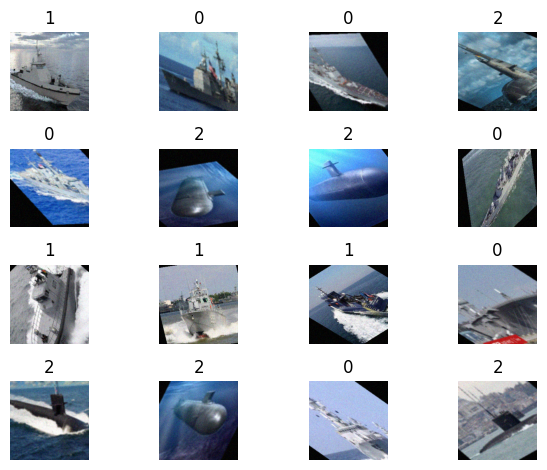

In [5]:
### START CODE HERE ###

dataset = CustomImageDataset(os.path.join(path, train_path))
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

images, labels = next(iter(data_loader))
plt.figure()

for i in range(4):
    for j in range(4):
        idx = i * 4 + j
        img = images[idx].numpy().transpose((1, 2, 0))
        plt.subplot(4, 4, idx + 1)
        plt.imshow(img)
        plt.title(labels[idx].item())
        plt.axis('off')

plt.tight_layout()       
plt.show()
### END CODE HERE ###

Questions
1. Discuss effects and benefits of fill_mode or padding_mode.
2. What would be amount of augmentation should be so that it would not effect the training performance?
3. How can we create Salt-and-Pepper Noise, which is the type that greatly affect the image quality?
4. What would be transform parameter to simulate camera lense effect?

Answers
1. เป็น parameter ที่ระบุว่าให้เติมค่า pixels บริเวณนอกขอบภาพเดิมยังไง เช่น "constant" เติมค่าคงที่ ex. สีดำ หรือ "reflect" จะสะท้อนค่า pixel จากขอบเข้ามา โดยมีประโยชน์คือ ทำให้การแปลงภาพดูเนียนขึ้น หรือป้องกันขอบขาวดำที่อาจรบกวนโมเดล และเพิ่มความหลากหลายในการเรียนรู้ของโมเดล
2. ควรมีความพอดี หรือ 1-3 โดยประมาณ ซึ่งจะเพิ่มความหลากหลายให้กับข้อมูล แต่ไม่ทำให้ภาพผิดเพี้ยนจนโมเดลสับสน เช่น random crop 5-10%, random rotatition ±15°, brightness/contrast 10–20%
ปรับเพิ่มทีละนิดแล้ว วัดผลด้วย validation set อย่าทำให้เปลี่ยน class semantics เช่น การหมุนที่ทำให้ 6 กลายเป็น 9
3. สุ่มเลือกจุดเล็กๆบนภาพ โดยเลือกประมาณ 1-5% แล้วเปลี่ยนค่าสีของ pixel เหล่านั้นเป็นค่าสีสูงสุด(255) สำหรับจุด "Salt" หรือค่าสีต่ำสุด(0) สำหรับจุด "Pepper" โดยทำแบบนี้ในทุกช่องสี (RGB) หรือถ้าเป็นภาพขาวดำก็เปลี่ยนแค่จุดเหล่านั้น ทำให้การจดจำรายละเอียดภาพยากขึ้น เหมาะกับการฝึกโมเดลให้ทนต่อภาพคุณภาพต่ำ
4. การจำลองเอฟเฟกต์จากเลนส์กล้องสามารถทำได้ด้วย 
transforms.GaussianBlur(kernel_size, sigma) -> จำลองการถ่ายผ่่นเลนส์ที่ไม่ชัด
transforms.CenterCrop(size) -> จำลองการถ่ายผ่านเสนส์ที่มีการซูมภาพ


In [6]:
# Salt and Pepper Noise

def add_salt_pepper(img, prob=0.02):
    img_np = np.array(img)
    output = img_np.copy()
    
    # จำนวน pixel ที่จะเปลี่ยน
    total_pixels = img_np.size
    num_salt = int(prob * total_pixels / 2)
    num_pepper = int(prob * total_pixels / 2)

    # Salt (white)
    coords = [np.random.randint(0, i - 1, num_salt) for i in img_np.shape]
    output[tuple(coords)] = 255

    # Pepper (black)
    coords = [np.random.randint(0, i - 1, num_pepper) for i in img_np.shape]
    output[tuple(coords)] = 0

    return Image.fromarray(output.astype(np.uint8))
